# Lab 3: A Conditional Generative Model for Images 
Welcome to lab 3! In the previous lab, we studied *unconditional* generation, for toy, two-dimensional data distributions. In this lab, we will study *conditional* generation on *images* from the MNIST dataset of handwritten digits. Each such MNIST image is not two dimensions but $32\times 32 = 1024$ dimensions! The nature of our new, more challenging setting will require us to take special care:
1. To tackle *conditional* generation, we will employ *classifier-free guidance* (CFG) (see Part 2.1).
2. To parameterize our learned vector field for high-dimensional image-valued data, a simple MLP will not suffice. Instead, we will adopt the *U-Net* architecture (see part 2.2).

If you find any mistakes, or have any other feedback, please feel free to email us at `erives@mit.edu` and `phold@mit.edu`. Enjoy!

In [1]:
from matplotlib import pyplot as plt
import torch
from flow_matching.supervised.alphas_betas import LinearAlpha, LinearBeta
from flow_matching.supervised.densities import MNISTSampler
from flow_matching.supervised.prob_paths import GaussianConditionalProbabilityPath
from torchvision.utils import make_grid
from flow_matching.supervised.model import MNISTUNet
from flow_matching.supervised.training import CFGTrainer
from flow_matching.supervised.odes_sdes import CFGVectorFieldODE
from flow_matching.supervised.simulators import EulerSimulator

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### Part 0: Recycling Components from Previous Labs
In this section, we'll re-import previous components from labs one and two. In doing so, we'll make some important updates. First, let's revisit our `Sampleable` class from labs one and two. Below, we have named it `OldSampleable`.

As we will see shortly, a dataset like MNIST contains both images (in this case handwritten digits), as well as class labels (a value from 0-9 indicating). We will therefore generalize our notion of `Sampleable` to accommodate these labels as well. Whereas the old, `OldSampleable.sample` method returned only `samples: torch.Tensor`, we will now have it return both `samples: torch.Tensor` *and* `labels: Optional[torch.Tensor]`. In this way, we are formally realizing every such `Sampleable` instance as sampling from a *joint distribution* over data and labels. We implement our new `Sampleable` below.

For certain distributions, such as a Gaussian, it doesn't really make sense to think about labels. For this reason we have made the labels return value Optional: a Gaussian can just return `None`. Below, we implement the class `IsotropicGaussian`.

Next, we make two updates in adding `ConditionalProbabilityPath` (and `GaussianConditionalProbabilityPath`):
1. We adjust to handle the addition of labels to `Sampleable`. Recall earlier that our called our conditioning variable `z` with $z \sim p_{\text{data}}(z)$. Now, we sample both `z`, as well as a label `y`, with $(z,y) \sim p_{\text{data}}(z,y)$.
2. We ensure that the logic is compatible with shapes of size `(batch_size, c, h, w)`, rather than `(batch_size, dim)`. While the latter was sufficient for 2D data of shape `(batch_size, 2)`, we will now be working with images which, when batched, have shape `(batch_size, c, h, w)`. Here `c`, `h`, and `w`, denote the number of channels, the height, and the width, respectively.
3. To avoid any unfortunate broadcasting issues, we will maintain our time variable `t` in the shape `(batch_size, 1, 1, 1)`.

Finally, we add back in `GaussianConditionalProbabilityPath`, along with `LinearAlpha` and `LinearBeta`, defined similarly to the previous lab. Here, we must be careful to avoid irksome broadcasting issues: broadcasting e.g., `alpha(t)` of shape `(batch_size, 1)` together with `x` of shape `(batch_size, c, h, w)` will not work! We alleviate this issue by ensuring that `alpha(t)` and `beta(t)` are, similarly to `t` itself, also both of shape `(batch_size, 1, 1, 1)`.

Now, let us accordingly update our `ODE`, `SDE`, and `Simulator` classes. This is pretty much a matter of 
1. Updating `t: (batch_size, 1)` to `t: (batch_size, 1, 1, 1)`, and `xt: (batch_size, dim)` to `(batch_size, c, h, w)`. For brevity, we will usually use `bs` as shorthand for `batch_size`.
2. Adding support for an optional *conditioning* input `y: Optional[torch.Tensor]`. We will opt to more simply add a generic `**kwargs` to the signatures of the relevant methods (`drift_coefficient`, `diffusion_coefficient`, `step`, `simulate`, etc.).

Finally, let's add back in our definition of `Trainer`.

# Part 1: Getting a Feel for MNIST
In this section, we'll get a feel for MNIST. We'll then experiment with adding noise to MNIST with `ConditionalGaussianProbabilityPath`.

Now let's view some samples under the conditional probability path.

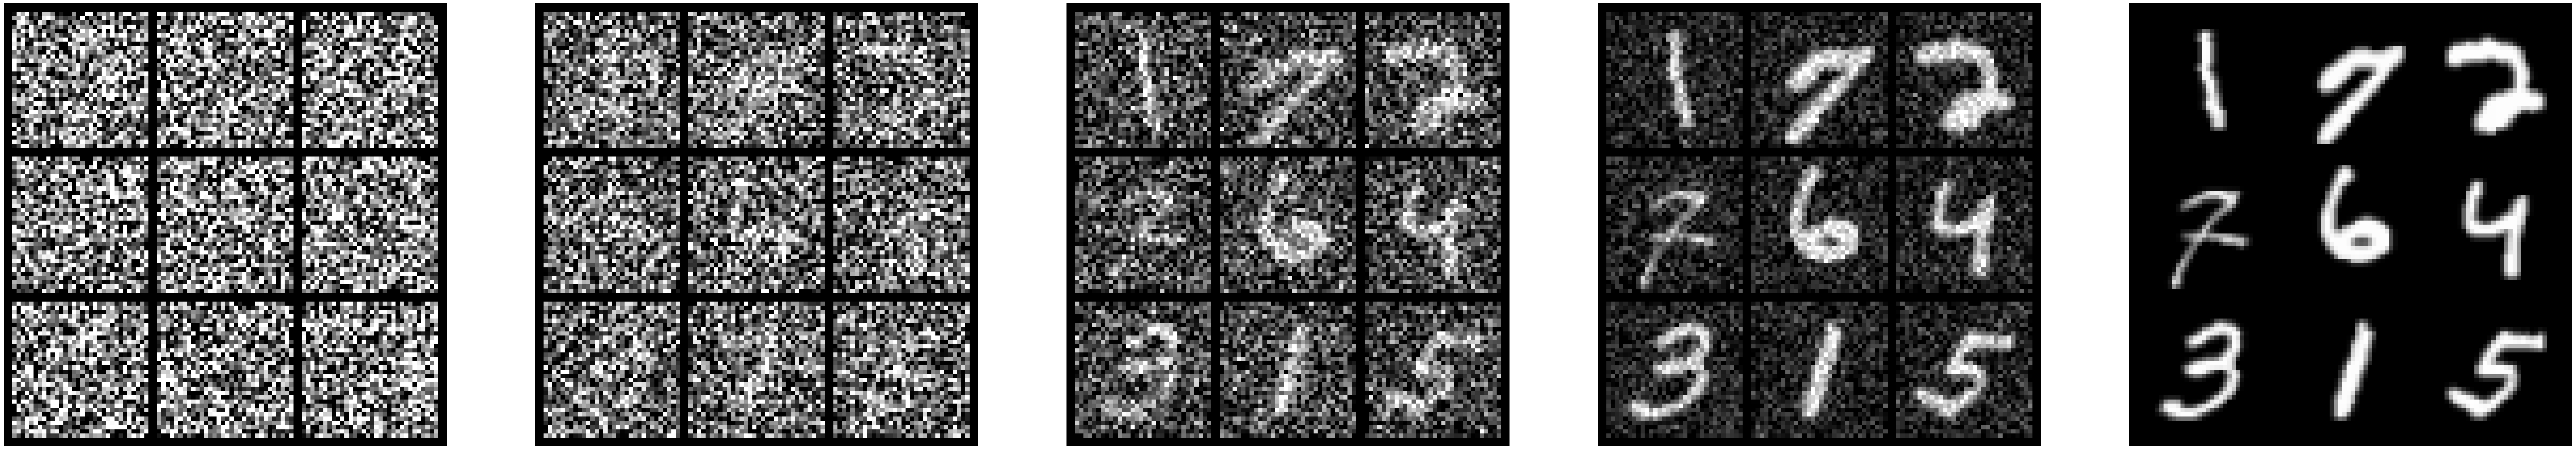

In [2]:
# Change these!
num_rows = 3
num_cols = 3
num_timesteps = 5

# Initialize our sampler
sampler = MNISTSampler().to(device)

# Initialize probability path
path = GaussianConditionalProbabilityPath(
    p_data=MNISTSampler(),
    p_simple_shape=[1, 32, 32],
    alpha=LinearAlpha(),
    beta=LinearBeta(),
).to(device)

# Sample
num_samples = num_rows * num_cols
z, _ = path.p_data.sample(num_samples)

# Setup plot
fig, axes = plt.subplots(
    1, num_timesteps, figsize=(6 * num_cols * num_timesteps, 6 * num_rows)
)

# Sample from conditional probability paths and graph
ts = torch.linspace(0, 1, num_timesteps).to(device)
for tidx, t in enumerate(ts):
    tt = t.view(1, 1, 1, 1).expand(num_samples, 1, 1, 1)  # (num_samples, 1, 1, 1)
    xt = path.sample_conditional_path(z, tt)  # (num_samples, 1, 32, 32)
    grid = make_grid(xt, nrow=num_cols, normalize=True, value_range=(-1, 1))
    axes[tidx].imshow(grid.permute(1, 2, 0).cpu(), cmap="gray")
    axes[tidx].axis("off")
plt.show()

# Part 2: Classifier Free Guidance

### Problem 2.1: Classifier Free Guidance

**Guidance**: Whereas for unconditional generation, we simply wanted to generate *any* digit, we would now like to be able to specify, or *condition*, on the identity of the digit we would like to generate. That is, we would like to be able to say "generate an image of the digit 8", rather than just "generate an image of a digit". We will henceforth refer to the digit we would like to generate as $x \in \mathbb{R}^{1 \times 32 \times 32}$, and the conditioning variable (in this case, a label), as $y \in \{0, 1, \dots, 9\}$. If we imagine fixing our choice of $y$, and take our data distribution as $p_{\text{simple}}(x|y)$, then we have recovered the unconditional generative problem, and we can construct a generative model using e.g., a conditional flow matching objective via $$\begin{align*}\mathcal{L}_{\text{CFM}}^{\text{guided}}(\theta;y) &= \,\,\mathbb{E}_{\square} \lVert u_t^{\theta}(x|y) - u_t^{\text{ref}}(x|z)\rVert^2\\ \square &= z \sim p_{\text{data}}(z|y), x \sim p_t(x|z)\end{align*}$$
We may now then allow $y$ to vary by simply taking our conditional flow matching expectation to be over $y$ as well (rather than fixing $y$), and explicitly conditioning our learned approximation on $u_t^{\theta}(x|y)$ on the choice of $y$. We therefore obtain the the *guided* conditional flow matching objective $$\begin{align*}\mathcal{L}_{\text{CFM}}(\theta) &= \,\,\mathbb{E}_{\square} \lVert u_t^{\theta}(x|y) - u_t^{\text{ref}}(x|z)\rVert^2\\ \square &= z,y \sim p_{\text{data}}(z,y), x \sim p_t(x|z)\end{align*}$$
Note that $(z,y) \sim p_{\text{simple}}(z,y)$ is obtained in practice by sampling an image $z$, and a label $y$, from our labelled (MNIST) dataset. This is all well and good, and we emphasize that if our goal was simply to sample from $p_{\text{data}}(x|y)$, our job would be done (at least in theory). In practice, one might argue that we care more about the *perceptual quality* of our images. To this end, we will a derive a procedure known as *classifier-free guidance*.

**Classifier-Free Guidance**: For the sake of intuition, we will develop guidance through the lense of Gaussian probability paths, although the final result might reasonably be applied to any probability path. Recall from the lecture that for $(a_t, b_t) = \left(\frac{\dot{\alpha}_t}{\alpha_t}, -\frac{\dot{\beta}_t \beta_t \alpha_t - \dot{\alpha}_t \beta_t^2}{\alpha_t}\right)$, we have $$u_t(x|y) = a_tx + b_t\nabla \log p_t(x|y).$$
This identity allows us to relate the *conditional marginal velocity* $u_t(x|y)$ to the *conditional score* $\nabla \log p_t(x|y)$. However, notice that $$\nabla \log p_t(x|y) = \nabla \log \left(\frac{p_t(x)p_t(y|x)}{p_t(y)}\right) = \nabla \log p_t(x) + \nabla \log p_t(y|x),$$
so that we may rewrite $$u_t(x|y) = a_tx + b_t(\nabla \log p_t(x) + \nabla \log p_t(y|x)) = u_t(x) + b_t \nabla \log p_t(y|x).$$
An approximation of the term $\nabla \log p_t(y|x)$ could be considered as a sort of noisy classifier (and in fact this is the origin of *classifier guidance*, which we do not consider here). In practice, people have noticed that the conditioning seems to work better when we scale the contribution of this classifier term, yielding
$$\tilde{u}_t(x|y) = u_t(x) + w b_t \nabla \log p_t(y|x)$$
where $w > 1$ is known as the *guidance scale*. We may then plug in $b_t\log p_t(y|x) = u^{\text{target}}_t(x|y) - u^{\text{target}}_t(x)$ to obtain $$\begin{align}\tilde{u}_t(x|y) &= u_t(x) + w b_t \nabla \log p_t(y|x)\\
&= u_t(x) + w (u^{\text{target}}_t(x|y) - u^{\text{target}}_t(x))\\
&= (1-w) u_t(x) + w u_t(x|y). \end{align}$$
The idea is thus to train both $u_t(x)$ as well as the conditional model $u_t(x|y)$, and then combine them *at inference time* to obtain $\tilde{u}_t(x|y)$. Our recipe will thus be:
1. Train $u_t^{\theta} \approx u_t(x)$ as well as the conditional model $u_t^{\theta}(x|y) \approx u_t(x|y)$ using conditional flow matching.
2. At inference time, sample using $\tilde{u}_t^{\theta}(x|y)$.

"But wait!", you say, "why must we train two models?". Indeed, we can instead treat $u_t(x)$ as $u_t(x|y)$, where $y=\varnothing$ denotes *the absence of conditioning*. We may thus augment our label set with a new, additional $\varnothing$ label, so that $y \in \{0,1,\dots, 9, \varnothing\}$. This technique is known as **classifier-free guidance** (CFG). We thus arrive at
$$\boxed{\tilde{u}_t(x|y) = (1-w) u_t(x|\varnothing) + w u_t(x|y)}.$$

**Training and CFG**: We must now amend our conditional flow matching objective to account for the possibility of $y = \varnothing$. Of course, when we sample $(z,y)$ from MNIST, we will never obtain $y = \varnothing$, so we must introduce the possibliity of this artificially. To do so, we will define some hyperparameter $\eta$ to be the *probability* that we discard the original label $y$, and replace it with $\varnothing$. In practice, we might set $\varnothing = 10$, for example, as it is sufficient to distinguish it from the other digit identities. When we go and implement our model, we need ony be able to index into some embedding, such as via `torch.nn.Embedding`. We thus arrive at our CFG conditional flow matching training objective:
$$\begin{align*}\mathcal{L}_{\text{CFM}}(\theta) &= \,\,\mathbb{E}_{\square} \lVert u_t^{\theta}(x|y) - u_t^{\text{ref}}(x|z)\rVert^2\\
\square &= z,y \sim p_{\text{data}}(z,y), x \sim p_t(x|z),\,\text{replace $y$ with $\varnothing$ with probability $\eta$}\end{align*}$$
In plain English, this objective reads:
1. Sample an image $z$ and a label $y$ from $p_{\text{data}}$ (here, MNIST).
2. With probability $\eta$, replace the label $y$ with the null label $\varnothing \triangleq 10$.
3. Sample $t$ from $\mathcal{U}[0,1]$.
4. Sample $x$ from the conditional probability path $p_t(x|z)$.
5. Regress $u_t^{\theta}(x|y)$ against $u_t^{\text{ref}}(x|z)$.


### Question 2.2: Training for Classifier-Free Guidance
In this section, you'll the training objective $\mathcal{L}_{\text{CFM}}(\theta)$ in which $u_t^{\theta}(x|y)$ is an instance of the class `ConditionalVectorField` described below.

**Your job**: Fill in `CFGFlowTrainer.get_train_loss`, so that it implements $\mathcal{L}_{\text{CFM}}(\theta)$ described above. In doing so, feel free to "hardcode" $\varnothing = 10$. A more general implementation would not make this MNIST-specific assumption, but for the sake of this assignment you may do so.

**Hints**:
1. To sample an image $(z,y) \sim p_{\text{data}}$, use `self.path.p_data.sample`
2. You can generate a mask corresponding to "probability $\eta$" via `mask = torch.rand(batch_size) < self.eta`. 
3. You can sample $t \sim \mathcal{U}[0,1]$ using `torch.rand(batch_size, 1, 1, 1)`. Don't mix up `torch.rand` with `torch.randn`!
4. You can sample $x \sim p_t(x|z)$ using `self.path.sample_conditional_path`.

# Part 3: An Architecture for Images
At this point, we have discussed classifier free guidance, and the necessary considerations that must be made on the part of our model and in training our model. What remains is to actually discuss the choice of model. In particular, our usual choice of an MLP, while fine for the simple distributions of the previous lab, will no longer suffice. To this end, we will a new convolutional architecture - the **U-Net** - which is specifically tailored toward images. A diagram of the U-Net we'll be using is shown below. 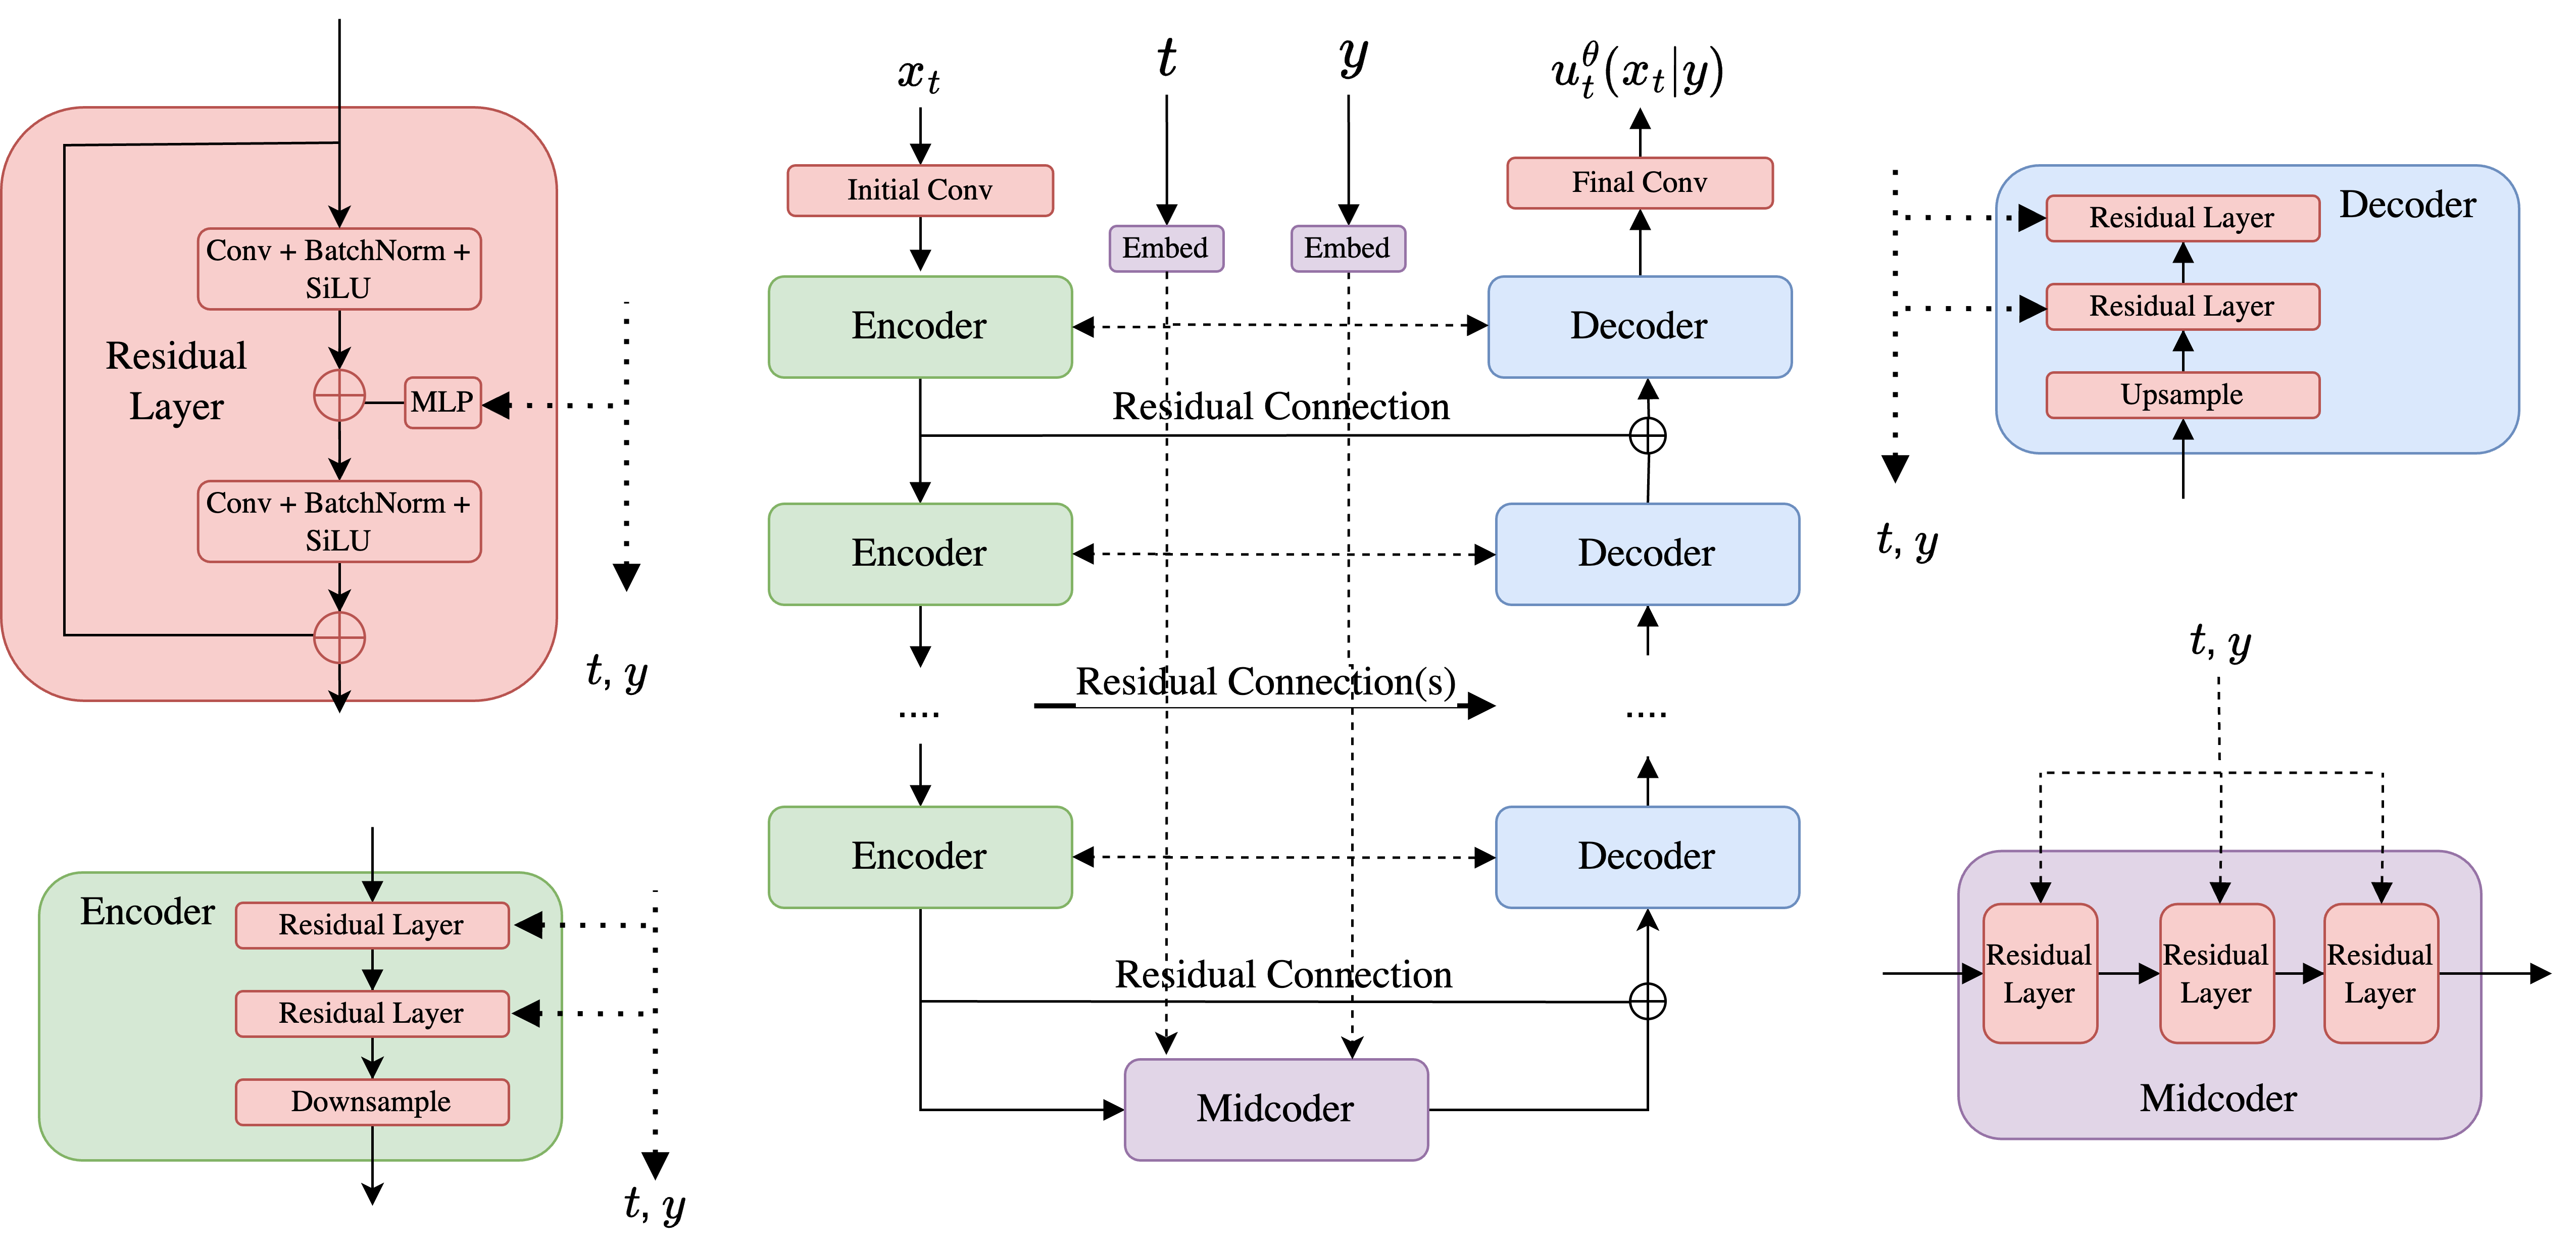

### Question 3.1: Building a U-Net

Below, we implement the U-Net shown in the diagram above.

**Your job**: Pick *two* components of the architecture above (each one of `FourierEncoder`, `ResidualLayer`, `Encoder`, `Decoder`, or `Midcoder`), and explain, in your own words, (1) their role in the U-Net, (2) their inputs and outputs, and (3) a brief description of how the inputs turn into outputs.

**Your answer**: 

### Question 3.2: Training a U-Net for Classifier-Free Guidance

Now let's train!

In [4]:
# Initialize probability path
path = GaussianConditionalProbabilityPath(
    p_data=MNISTSampler(),
    p_simple_shape=[1, 32, 32],
    alpha=LinearAlpha(),
    beta=LinearBeta(),
).to(device)

# Initialize model
unet = MNISTUNet(
    channels=[16, 32, 64],  # [32, 64, 128],
    num_residual_layers=2,
    t_embed_dim=8,  # 40,
    y_embed_dim=8,  # 40,
)

# Initialize trainer
trainer = CFGTrainer(path=path, model=unet, eta=0.1)

In [7]:
# Train!
# trainer.train(num_epochs=5000, device=device, lr=1e-3, batch_size=250)
trainer.train(num_epochs=1000, device=device, lr=1e-3, batch_size=32)

Training model with size: 1.132 MiB


Epoch 999, loss: 0.200: 100%|██████████| 1000/1000 [04:24<00:00,  3.78it/s]


How well does our model do? Let's find out! We'll use the class `CFGVectorFieldODE` to wrap the UNet in an instance of `ode` so that we can integrate it!

In [ ]:
# save model
# torch.save(unet.state_dict(), "unet.pt")

100%|██████████| 31/31 [00:04<00:00,  7.18it/s]


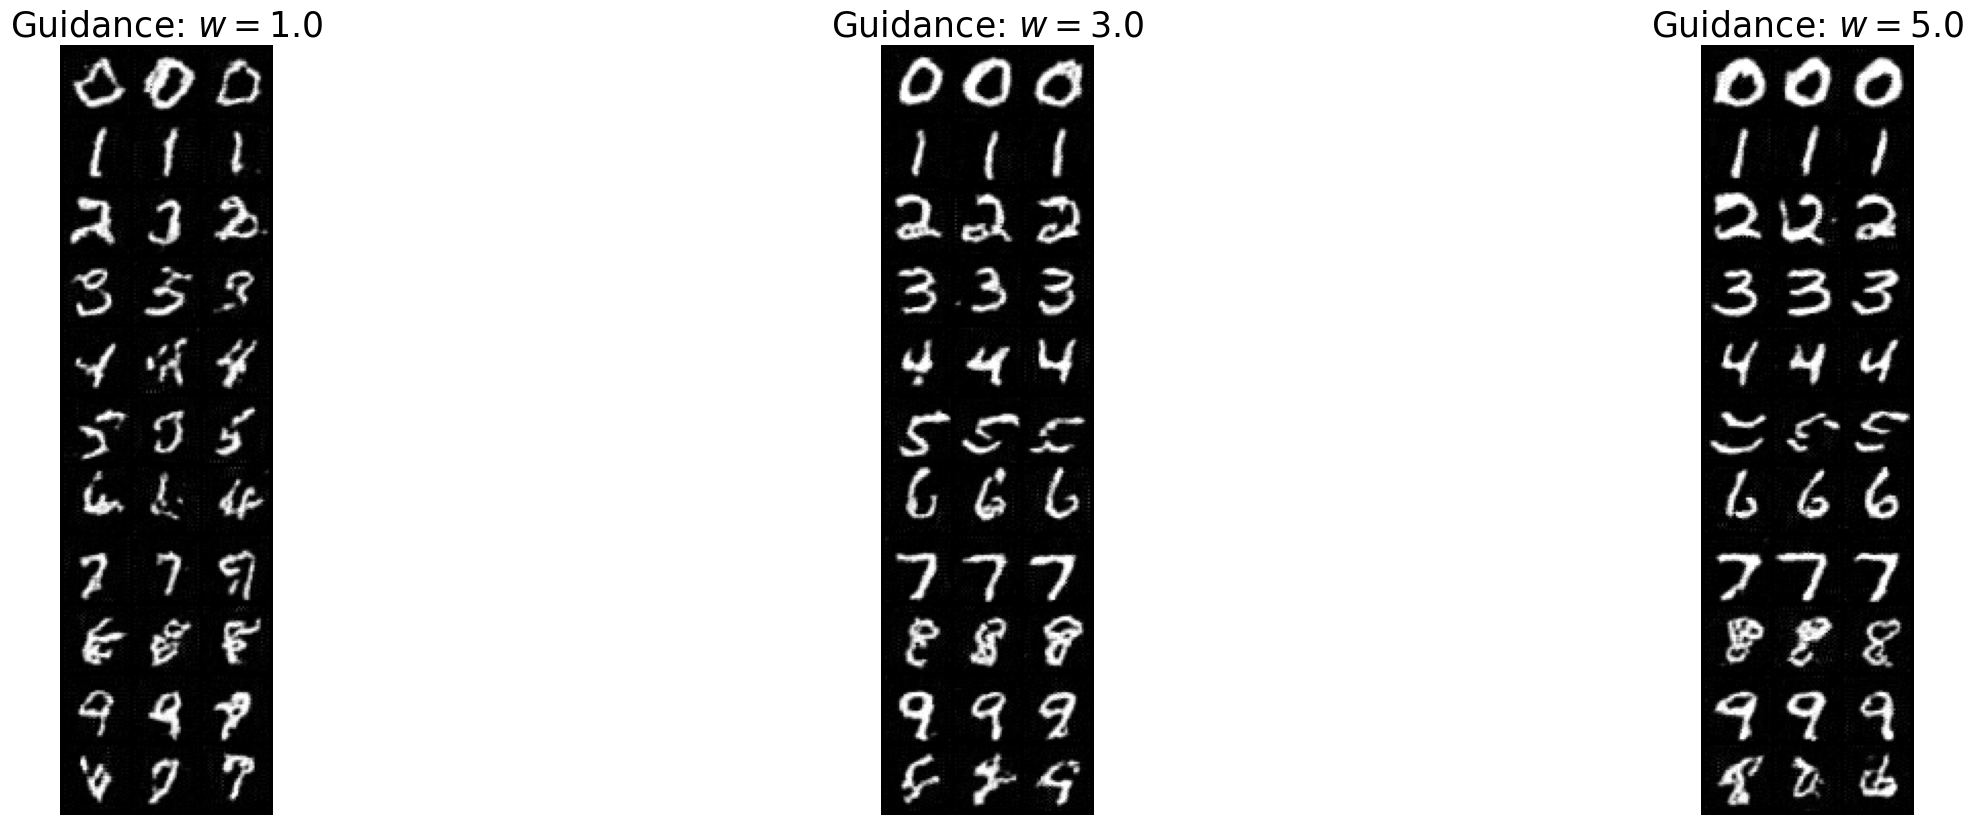

In [8]:
# Play with these!

samples_per_class = 3  # 10
num_timesteps = 32  # 100
guidance_scales = [1.0, 3.0, 5.0]

# Graph
fig, axes = plt.subplots(
    1, len(guidance_scales), figsize=(10 * len(guidance_scales), 10)
)

for idx, w in enumerate(guidance_scales):
    # Setup ode and simulator
    ode = CFGVectorFieldODE(unet, guidance_scale=w)
    simulator = EulerSimulator(ode)

    # Sample initial conditions
    y = (
        torch.tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10], dtype=torch.int64)
        .repeat_interleave(samples_per_class)
        .to(device)
    )
    num_samples = y.shape[0]
    x0, _ = path.p_simple.sample(num_samples)  # (num_samples, 1, 32, 32)

    # Simulate
    ts = (
        torch.linspace(0, 1, num_timesteps)
        .view(1, -1, 1, 1, 1)
        .expand(num_samples, -1, 1, 1, 1)
        .to(device)
    )
    x1 = simulator.simulate(x0, ts, y=y)

    # Plot
    grid = make_grid(x1, nrow=samples_per_class, normalize=True, value_range=(-1, 1))
    axes[idx].imshow(grid.permute(1, 2, 0).cpu(), cmap="gray")
    axes[idx].axis("off")
    axes[idx].set_title(f"Guidance: $w={w:.1f}$", fontsize=25)
plt.show()

**Your job:** What do you notice about our samples as the quality improves? Why might increasing the guidance scale $w$ have this affect? Propose an intuitive explanation in your own words.

**Your answer**: 